## Loading prems

In [ ]:
from typing import Optional

import jax.numpy
import numpy


def gaussian_mixture_energy(coord, means, sigmas, weights):
    """
        Implements an isotropic gaussian mixture energy function.
        This is a good distribution for debugging sampler implementation

        $\sum_{i=O}^{K-1}  w_i  \mathcal N (means_i, sigmas_i)$

        :param coord : [[x,y]] point of shape=(1,2) at which to compute energy.
        :param means : array of 2D means (shape=(K, 2)) for each gaussian dist in mixture
        :param sigmas: array of scalers (shape=(K,)) describing std of each gaussian dist in mixture
        :param weights: array of scalers (shape=(K,)) describing weights of each gaussian dist in mixture
        :return energy value (or -log of unnormalized density)
    """

    diff = coord - means
    numerator = jax.numpy.sum(diff ** 2, axis=1)

    mode_densities = jax.numpy.exp(- numerator / (2 * sigmas ** 2)) / sigmas
    density = jax.numpy.sum(weights * mode_densities)
    return -jax.numpy.log(density)


def gaussian_mixture_sampler(N, means, sigmas, weights, key):
    """
        Implements sampling from an isotropic gaussian mixture energy function.
        This is a good distribution for debugging sampler implementation

        $\sum_{i=O}^{K-1}  w_i  \mathcal N (means_i, sigmas_i)$

        :param N : number of samples to generate
        :param means : array of 2D means (shape=(K, 2)) for each gaussian dist in mixture
        :param sigmas: array of scalers (shape=(K,)) describing std of each gaussian dist in mixture
        :param weights: array of scalers (shape=(K,)) describing weights of each gaussian dist in mixture
        :param key: JAX needs a key for its random number generator, it is just that
        :return samples shape=(N,2)
    """

    # first sample modes
    subkey, key = jax.random.split(key)
    modes = jax.random.choice(subkey, len(weights), shape=(N,), p=weights)

    shape = (N,) + means.shape[1:]
    subkey, key = jax.random.split(key)
    std_normal_samples = jax.random.normal(subkey, shape=shape)
    return std_normal_samples * sigmas[modes].reshape(std_normal_samples.shape[0], 1) + means[modes]


def sample_from_image_density(N, density, key):
    """
        adapted from https://github.com/noegroup/stochastic_normalizing_flows/blob/main/snf_code/snf_code/image.py#L138

        This samples a bin with probability given by density and then perturb the coordinate of bin uniformly

        :param N: number of samples
        :param density: density or value at each pixel
        :param key: JAX needs a key for its random number generator, it is just that
        :return: samples shape=(N,2)
    """
    # normalize
    density = density / density.sum()

    flat_density = density.flatten()
    subkey, key = jax.random.split(key)
    indices = jax.random.choice(subkey, a=len(flat_density), shape=(N,), p=flat_density)

    bins = jax.numpy.stack([indices // (density.shape[0]), indices % (density.shape[0])], axis=1)
    subkey, key = jax.random.split(key)
    samples = bins + jax.random.uniform(subkey, shape=bins.shape) - 0.5
    return samples


def continuous_energy_from_image(coord, xp, yp, zp, fill_value=None):
    """

    :param coord:
    :param xp: see interp2d
    :param yp: see interp2d
    :param zp: see interp2d
    :param fill_value: see interp2d (Note: you can this to enforce some trivial boundary conditions
    :return: energy (based on bilinear interpolation of zp on xp, yp grid. )
    """
    return -jax.numpy.log(interp2d(coord[0], coord[1], xp, yp, zp, fill_value))


def interp2d(
        x: jax.numpy.ndarray,
        y: jax.numpy.ndarray,
        xp: jax.numpy.ndarray,
        yp: jax.numpy.ndarray,
        zp: jax.numpy.ndarray,
        fill_value: Optional[jax.numpy.ndarray] = None,
) -> jax.numpy.ndarray:
    """
    Taken from "https://github.com/adam-coogan/jaxinterp2d/blob/master/src/jaxinterp2d/__init__.py"
    Bilinear interpolation on a grid. ``CartesianGrid`` is much faster if the data
    lies on a regular grid.
    Args:
        x, y: 1D arrays of point at which to interpolate. Any out-of-bounds
            coordinates will be clamped to lie in-bounds.
        xp, yp: 1D arrays of points specifying grid points where function values
            are provided.
        zp: 2D array of function values. For a function `f(x, y)` this must
            satisfy `zp[i, j] = f(xp[i], yp[j])`
    Returns:
        1D array `z` satisfying `z[i] = f(x[i], y[i])`.
    """
    if xp.ndim != 1 or yp.ndim != 1:
        raise ValueError("xp and yp must be 1D arrays")
    if zp.shape != (xp.shape + yp.shape):
        raise ValueError("zp must be a 2D array with shape xp.shape + yp.shape")

    ix = jax.numpy.clip(jax.numpy.searchsorted(xp, x, side="right"), 1, len(xp) - 1)
    iy = jax.numpy.clip(jax.numpy.searchsorted(yp, y, side="right"), 1, len(yp) - 1)

    # Using Wikipedia's notation (https://en.wikipedia.org/wiki/Bilinear_interpolation)
    z_11 = zp[ix - 1, iy - 1]
    z_21 = zp[ix, iy - 1]
    z_12 = zp[ix - 1, iy]
    z_22 = zp[ix, iy]

    z_xy1 = (xp[ix] - x) / (xp[ix] - xp[ix - 1]) * z_11 + (x - xp[ix - 1]) / (
            xp[ix] - xp[ix - 1]
    ) * z_21
    z_xy2 = (xp[ix] - x) / (xp[ix] - xp[ix - 1]) * z_12 + (x - xp[ix - 1]) / (
            xp[ix] - xp[ix - 1]
    ) * z_22

    z = (yp[iy] - y) / (yp[iy] - yp[iy - 1]) * z_xy1 + (y - yp[iy - 1]) / (
            yp[iy] - yp[iy - 1]
    ) * z_xy2

    if fill_value is not None:
        oob = jax.numpy.logical_or(
            x < xp[0], jax.numpy.logical_or(x > xp[-1], jax.numpy.logical_or(y < yp[0], y > yp[-1]))
        )
        z = jax.numpy.where(oob, fill_value, z)

    return z


def prepare_image(rgb, crop=None, embed=None, white_cutoff=225, gauss_sigma=3, background=0.01):
    """
    Taken from https://github.com/noegroup/stochastic_normalizing_flows/blob/main/snf_code/snf_code/image.py
    Transforms rgb image array into 2D-density and energy
    Parameters:
        rgb: RGB image

     ----------
    density : ndarray(width, height)
        Probability density
    energy : ndarray(width, height)
        Energy
    """
    img = rgb

    # make one channel
    img = img.mean(axis=2)

    # make background white
    img = img.astype(numpy.float32)
    img[img > white_cutoff] = 255

    # normalize
    img /= img.max()

    if crop is not None:
        # crop
        img = img[crop[0]:crop[1], crop[2]:crop[3]]

    if embed is not None:
        tmp = numpy.ones((embed[0], embed[1]), dtype=numpy.float32)
        shift_x = (embed[0] - img.shape[0]) // 2
        shift_y = (embed[1] - img.shape[1]) // 2
        tmp[shift_x:img.shape[0] + shift_x, shift_y:img.shape[1] + shift_y] = img
        img = tmp

    # convolve with Gaussian
    from scipy.ndimage import gaussian_filter
    img2 = gaussian_filter(img, sigma=gauss_sigma)

    # add background
    background1 = gaussian_filter(img, sigma=10)
    background2 = gaussian_filter(img, sigma=20)
    background3 = gaussian_filter(img, sigma=50)
    density = (1.0 - img2) + background * (background1 + background2 + background3)

    U = -numpy.log(density)
    U -= U.min()

    return density, U

# see NPEET for different type of information-theoretic metrics
from typing import List, Union

import numpy


def compute_2d_histogram_from_samples(samples, density):
    """
        Compute 2D histogram from samples for samples on a 2D grid.
        This is to be used when sampling from image's density.

    :param samples: 2D samples from image density
    :param density: density derived from the image
    :return: unnormalized density with bin_size 1
    """

    x_dim, y_dim = density.shape

    sample_density, xedges, yedges = numpy.histogram2d(
        samples[:, 0], samples[:, 1], bins=[numpy.arange(0, x_dim + 1), numpy.arange(0, y_dim + 1)],
        density=False
    )

    return sample_density


def compute_coarse_discretization(density, bin_size):
    if isinstance(bin_size, int):
        bin_size = [bin_size, bin_size]

    bin_size_x, bin_size_y = bin_size

    x_dim, y_dim = density.shape

    density_new = numpy.zeros(((x_dim + 1) // bin_size_x, (y_dim + 1) // bin_size_y))
    for i in range(0, density_new.shape[0]):
        for j in range(0, density_new.shape[1]):
            density_new[i, j] = (
                density[i * bin_size_x:(i + 1) * bin_size_x][:,
                j * bin_size_y:(j + 1) * bin_size_y]).sum()

    return density_new


def get_discretized_tv_for_image_density(density, samples, bin_size: Union[int, List[int]] = 1):
    if isinstance(bin_size, int):
        bin_size = [bin_size, bin_size]

    sample_density = compute_2d_histogram_from_samples(samples, density)

    density = compute_coarse_discretization(density, bin_size)
    sample_density = compute_coarse_discretization(sample_density, bin_size)

    sample_density = sample_density / sample_density.sum()
    density = density / density.sum()
    breakpoint()
    return (numpy.abs(density - sample_density)).sum()


## Installing related packages

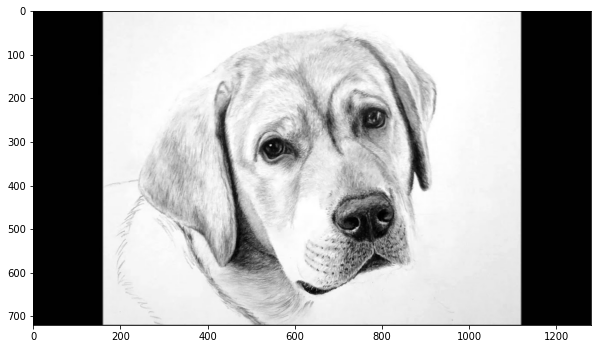

In [ ]:
import matplotlib.image
import matplotlib.pyplot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rcParams, ticker, cm
from matplotlib import collections as mc
import numpy as onp 
rcParams['animation.html'] = 'jshtml'  # Makes the default animation an interactive video
rcParams['animation.embed_limit'] = 2**128  # Allow bigger animations

img = matplotlib.image.imread('/content/drive/MyDrive/CS699/homework #2/labrador.jpg')

# plot and visualize
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
matplotlib.pyplot.show()

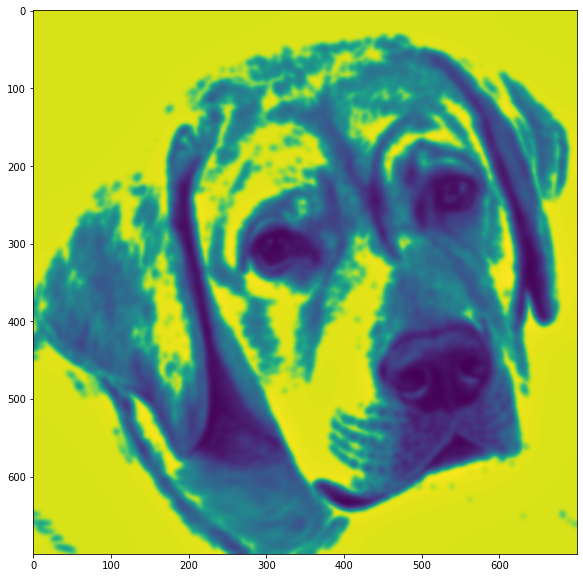

In [ ]:
import jax

density, energy = prepare_image(
    img, crop=(10, 710, 240, 940), white_cutoff=225, gauss_sigma=3, background=0.01
)

x_max, y_max = density.shape
xp = jax.numpy.arange(x_max)
yp = jax.numpy.arange(y_max)
zp = jax.numpy.array(density)

# You may use fill value to enforce some boundary conditions or some other way to enforce boundary conditions
energy_fn = lambda coord: continuous_energy_from_image(coord, xp, yp, zp, fill_value=0)
energy_fn_grad = jax.grad(energy_fn)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(energy)
matplotlib.pyplot.show()

In [ ]:
import jax.numpy as np
import jax
from jax import random

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

def hamiltonian_monte_carlo(x0, f, k, epsilon):
    """Run HMC for k steps, with step size epsilon"""
    v = onp.random.randn(*x0.shape)  # Not the correct way to get randoms in JAX
    g = jax.grad(f)  # Gradient of energy function
    x = x0  # save the original state, in case we reject the update
    for i in range(k):
        v = v - 0.5 * epsilon * g(x)  # half step in v
        x = x + epsilon * v  # full step in x
        v = v - 0.5 * epsilon * g(x)  # half step in v  
        # more efficient to combine half-steps
    if onp.random.random() > np.exp(f(x0) - f(x)):
        print("Metropolis- Hastings REJECT", f(x0), f(x))
        x = x0
    return x

In [ ]:
## Couple of different strategies: use multiple runs from one sample vs. use a run from multiple samples

d = 2  # dimensionality 
n_iter = 3000
k = 200
epsilon = 0.1

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)  

for i in range(n_iter):
    key = jax.random.PRNGKey(i)
    key, subkey = jax.random.split(key)
    init_sample = sample_from_image_density(1, density, subkey).flatten()
    sampled_outputs[0, i] = hamiltonian_monte_carlo(init_sample, energy_fn, k, 0.01)

Metropolis- Hastings REJECT 1.6554933 2.0143814
Metropolis- Hastings REJECT 2.243117 3.01026
Metropolis- Hastings REJECT 0.2367889 0.34715194
Metropolis- Hastings REJECT 0.46168214 0.52051693
Metropolis- Hastings REJECT 1.5695392 1.7568407
Metropolis- Hastings REJECT 1.0694536 1.1286373
Metropolis- Hastings REJECT 0.37286493 0.4901055
Metropolis- Hastings REJECT 3.4907217 3.6206903
Metropolis- Hastings REJECT 1.5599419 1.8910792
Metropolis- Hastings REJECT 0.5409864 0.74888355
Metropolis- Hastings REJECT 2.5019865 3.2466106
Metropolis- Hastings REJECT 1.0700214 1.1449745
Metropolis- Hastings REJECT 2.213927 3.2965817
Metropolis- Hastings REJECT 0.1731989 0.19979659
Metropolis- Hastings REJECT 1.3141502 1.3755561
Metropolis- Hastings REJECT 0.6408876 0.6630577
Metropolis- Hastings REJECT 0.118860446 0.259404
Metropolis- Hastings REJECT 1.6036906 1.95694
Metropolis- Hastings REJECT 2.1532078 2.4323013
Metropolis- Hastings REJECT 2.5451155 2.917179
Metropolis- Hastings REJECT 0.17258848 0

In [ ]:
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 0], sampled_outputs[:, :, 1], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()